# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from keras import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.backend import epsilon

import tensorflow as tf

from PIL import Image

Using TensorFlow backend.
C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

### Change directory

In [2]:
os.getcwd()
# By defalut the directory is pointing to Internal, so no need to change it (at least on my machine)

'D:\\Beejal\\Education\\Great Lakes\\Residency-09\\Course-Lab\\Internal'

### Load the training data from train.csv file

In [3]:
TRAIN_CSV = f'{os.getcwd()}{os.sep}train_labels.csv'
IMAGE_SIZE = 128   # We are using MobileNet which accepts input image size as 128*128

In [4]:
# Let's construct the image zip file path

image_file_name = 'images_racoon'
image_file_name_ext = '.rar'
images_zip_path = f'{os.getcwd()}{os.sep}{image_file_name}{image_file_name_ext}'

if (os.path.exists(f'{os.getcwd()}{os.sep}images') == False):
    print("Unzipping...")
    import patoolib
    patoolib.extract_archive(images_zip_path, outdir=os.getcwd())
#     from zipfile import ZipFile
#     with ZipFile(images_zip_path, 'r') as z:
#         z.extractall()    
    print("Complete")
else:
    print("Already Unzipped file exists. So skipping Unzipping.")


Already Unzipped file exists. So skipping Unzipping.


### Print the shape of the train dataset

In [5]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for row_index, row in enumerate(reader):
         
        # Following for loop just casts the numeric data (which is available in index 1 to 6) as int
        for i, r in enumerate(row[1:]): # Parse row with seven entities
            # The column on index 3 is class, so need not cast it to int
            if i != 2 :
                row[i+1] = int(r)
        
        # x0, y0 - Lower left  co-ordinates of Bounding Box on X & Y axis respectively w.r.t. Original Image size
        # x1, y1 - Upper Right co-ordinates of Bounding Box on X & Y axis respectively w.r.t. Original Image size
        # coords[0], coords[1] - Lower left Co-ordinates of Bounding Box on X & Y axis respectively w.r.t. Scaled Down Image size
        # coords[2], coords[3] - Width & Height of Bounding Box relative to coords[0], coords[1] w.r.t. Scaled Down Image size
        path, image_height, image_width, _, x0, y0, x1, y1 = row  
        path = f'{os.getcwd()}{os.sep}images{os.sep}{path}'
        coords[row_index, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[row_index, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[row_index, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[row_index, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)

batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

print("Loaded image files from file-system to memory")

Loaded image files from file-system to memory


In [6]:
# Shape of train dataset
batch_images.shape

# So we got 173 images in train dataset. Each with size (actually resized) 128*128*3

(173, 128, 128, 3)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [7]:
# DONE ABOVE

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [8]:
# Done above
len(paths), len(coords)

(173, 173)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [9]:
# Done above

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [10]:
# controls the width of the network
# If alpha < 1.0, proportionally decreases the number of filters in each layer.
# If alpha > 1.0, proportionally increases the number of filters in each layer.
# If alpha = 1, default number of filters from the paper are used at each layer.
ALPHA = 1

# I tried changing ALPHA to 1.2 but it gives error
# "If imagenet weights are being loaded, alpha can be one of`0.25`, `0.50`, `0.75` or `1.0` only."
# So it seems like we cannot go beyond 1 if we are using the imagenet weights

In [11]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# We are using pre-trained MobileNet Architecture & Learned weights. In order to leverage what has already been learned
# by this model (Transfer Learning), let us make all the layers of this model Non-Trainable.
for layer in model.layers:
    layer.trainable = False

model.output

<tf.Tensor 'conv_pw_13_relu/Relu6:0' shape=(?, 4, 4, 1024) dtype=float32>

In [12]:
# Let's now plug our layers to the TENSOR which is output from MobileNet 

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [13]:
def loss(gt, pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [14]:
EPOCHS = 30
BATCH_SIZE = 32
VERBOSE = 1
PATIENCE=5

In [15]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#es = EarlyStopping(monitor="IoU", patience=5, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="IoU", factor=0.2, patience=PATIENCE, min_lr=1e-7, verbose=VERBOSE, mode="max")
# Reduce learning rate if Validation IOU does not improve

gt = coords
model.fit(batch_images, gt,
            epochs=EPOCHS, 
            batch_size = BATCH_SIZE,
            verbose=VERBOSE,
            callbacks=[reduce_lr])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    

Epoch 1/30
173/173 [==============================] - 2s 10ms/step - loss: 3289.8776 - IoU: 0.0927
Epoch 2/30
173/173 [==============================] - 0s 1ms/step - loss: 991.0987 - IoU: 0.3721
Epoch 3/30
173/173 [==============================] - 0s 1ms/step - loss: 910.7955 - IoU: 0.4205
Epoch 4/30
173/173 [=============

### Pick a test image from the given data

In [23]:
import cv2
filename = './images/raccoon-180.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [24]:
unscaled.shape

(400, 600, 3)

In [25]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [26]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

142 6 619 299


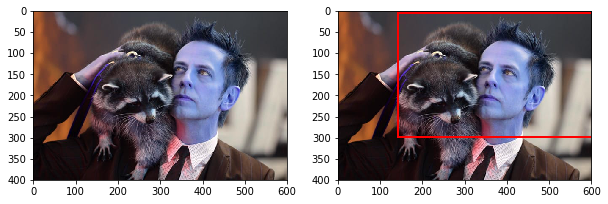

In [29]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

print(x0, y0, x1, y1)
bbox_width = x1 - x0
bbox_height = y1 - y0

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(unscaled)

# Display the image
ax[1].imshow(unscaled)

# Create a Rectangle patch 
rect = patches.Rectangle((x0, y0), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[1].add_patch(rect)

plt.show()

178 14 552 266


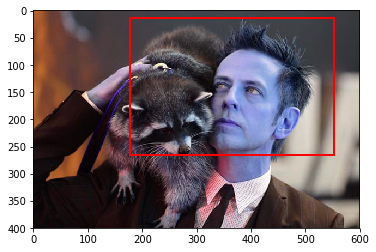

In [31]:
# Let's see how the bounding box was drawn in original image

filename = 'raccoon-180.jpg'
path = f'{os.getcwd()}{os.sep}images{os.sep}{filename}'
unscaled = cv2.imread(path) # Original image for display

# From paths list, let's figure out the index of this image. 
idx = paths.index(path)
#print(coords[idx])

image_height, image_width, _ = unscaled.shape

x0 = int(coords[idx][0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(coords[idx][1] * image_height / IMAGE_SIZE)

x1 = int((coords[idx][0] + coords[idx][2]) * image_width / IMAGE_SIZE)
y1 = int((coords[idx][1] + coords[idx][3]) * image_height / IMAGE_SIZE)

print(x0, y0, x1, y1)
bbox_width = x1 - x0
bbox_height = y1 - y0

fig, ax = plt.subplots(1)

ax.imshow(unscaled)

# Create a Rectangle patch 
rect = patches.Rectangle((x0, y0), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()